# MEWpy Optimization


Author: Vitor Pereira

License: [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

-------

In this tutorial:

- You will learn how to run combinatorial optimization on microbial communities using MEWpy

## Bacterial cross-feeding via extensive gene loss

Metabolic dependencies between microbial species have a significant impact on the
assembly and activity of microbial communities. However, the evolutionary origins of
such dependencies and the impact of metabolic and genomic architecture on their
emergence are not clear.

Recently, [McNally et al.](https://doi.org/10.1186/s12918-018-0588-4) proposed a method to evolve
cooperative interactions among microbial species by fostering cross-feeding of a
diverse set of metabolites. This was achieved by incrementaly deleting genes on
initially two identical bacterias (E. coli) and increasingly imposing constraints on the
community metabolic network such that two new strains evolve and start to diverge
while maximizing the differences on their genotypes.

The aim is to replicate the experiments using
MEWpy to maximize the number of deleted genes on the two strains
while inducing cross-feeding. 

### Run in Google colab

If you are running this notebook in Colab, you need to perform the following steps, otherwise skip.

In [1]:
%%bash
[[ ! -e /colabtools ]] && exit
! pip install -U -q PyDrive

In [2]:
if 'google.colab' in str(get_ipython()):
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    model_file = drive.CreateFile({'id':'1o0XthuEOs28UJ4XTa9SfFSFofazV-2nN'})
    model_file.GetContentFile('e_coli_core.xml.gz')

## Step 1 - Load the model

In [3]:
from cobra.io import read_sbml_model
import warnings
warnings.filterwarnings('ignore')

model = read_sbml_model('models/ec/e_coli_core.xml.gz')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-11


We will make two copies of the model and rename the two strains

In [4]:
from mewpy import get_simulator
wildtype = get_simulator(model)

In [5]:
ec1 = wildtype.copy()
ec1.id = 'ec1'
ec2 =wildtype.copy()
ec2.id = 'ec2'

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp52jr2h38.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp7_8udlxf.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


In the experiment, we will use the medium defined in the model

In [6]:
from mewpy.simulation import Environment
medium = Environment.from_model(wildtype)
medium

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpno2v1xi0.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


,lb,ub
EX_ac_e,0.0,1000.0
EX_acald_e,0.0,1000.0
EX_akg_e,0.0,1000.0
EX_co2_e,-1000.0,1000.0
EX_etoh_e,0.0,1000.0
EX_for_e,0.0,1000.0
EX_fru_e,0.0,1000.0
EX_fum_e,0.0,1000.0
EX_glc__D_e,-10.0,1000.0
EX_gln__L_e,0.0,1000.0


## Step 2 - Find single strain gene KOs

Two make the search for combinatorial gene deletion on the community model, we will first idenfify combinatorial gene delerions in one strain, and use these results to seed the community gene deletions.

We start by defining a gene deletion optimization problem (`GKOProblem`) defining as objective the maximization of biomass production (f1) and the maximization of the number of deletions.

In [7]:
from mewpy.problems import GKOProblem
from mewpy.optimization.evaluation import TargetFlux, CandidateSize

In [8]:
f1 = TargetFlux(wildtype.biomass_reaction,method='FBA')
f2 = CandidateSize(maximize=True)

To simpilfy the problem, we will define a maximum of 30 gene deletion and run 10 optimization iterations.

In [9]:
problem = GKOProblem(wildtype,
                     [f1,f2],
                     candidate_max_size = 30)


In [10]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=10)
gkos = ea.run(simplify=False)

Building modification target list.


100%|███████████████████████████████████████| 137/137 [00:00<00:00, 2722.75it/s]

Running NSGAII


Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp0lq4wf_a.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpw6bbk62k.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp3jnvqy_p.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp6c9ebryt.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp5c3wmxym.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmphwixz8t3.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/fold

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpeet6t4jj.lp
Reading time = 0.00 seconds
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpm5387uaj.lp
: 72 rows, 190 columns, 720 nonzeros
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmprc8qme3y.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp5anqx6n3.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpivblmpb8.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpw9qkp56_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/fold

Reading time = 0.00 seconds
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpwpt5jodw.lp
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpvygrn10p.lp
Reading time = 0.01 seconds
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmplkyq2f1u.lp
Reading time = 0.02 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpv93bknet.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmppyz82g64.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmppr5nszze.lp
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpwp107rlb.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjypu2ygi.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpnhy9stqv.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpncxkg0nv.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpb5cmplhy.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp1zgqph3f.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/fold

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpiqn3sd3a.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp94id5y8t.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp4ekfnsaq.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpt3zvwtz7.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpuxse_ewe.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjvly43y3.lp
Reading time = 0.00 seconds
: 72 rows, 1

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpgnmmji4e.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpaa0y4uo_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp8wg8o6lj.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmprwwcb3in.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpq_ul9x71.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_wyzoqpb.lp
Reading time = 0.00 seconds
: 72 rows, 1

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


We can have a look to the solution found by the evolutionary algoritm (EA)

In [11]:
ea.dataframe()

,Modification,Size,TargetFlux,Size
0,"{'b1276': 0, 'b0809': 0, 'b4154': 0, 'b0810': ...",30,0.374230,30.0
1,"{'b1817': 0, 'b1276': 0, 'b1723': 0, 'b0809': ...",22,0.873922,22.0
2,"{'b0356': 0, 'b0726': 0, 'b4395': 0, 'b0903': ...",23,0.782351,23.0
3,"{'b1276': 0, 'b0809': 0, 'b4154': 0, 'b0810': ...",27,0.680085,27.0
4,"{'b2465': 0, 'b2463': 0, 'b1676': 0, 'b1723': ...",17,0.873922,17.0
...,...,...,...,...
59,"{'b3738': 0, 'b4154': 0, 'b3925': 0, 'b2579': ...",26,0.374230,26.0
60,"{'b2465': 0, 'b3403': 0, 'b4395': 0, 'b0485': ...",11,0.873922,11.0
61,"{'b1676': 0, 'b1723': 0, 'b0755': 0, 'b2976': ...",11,0.873922,11.0
62,"{'b3738': 0, 'b1276': 0, 'b3870': 0, 'b2288': ...",30,0.167609,30.0


and run an FBA on the first solution (the biomass is set by default as objective)

In [12]:
problem.simulate(solution=gkos[0].values)

objective: 0.3742298749331099
Status: OPTIMAL
Method:FBA

We may now generate solutions that will seed the EA to be used later in the community gene deletions.

In [13]:
import random

init_pop = []
for s in gkos:
    x=s.values
    init_pop.append([k+'_ec1' for k in x.keys()])
    init_pop.append([k+'_ec2' for k in x.keys()])

random.shuffle(init_pop)


## Community mutants 

We can now address our main goal, starting by defining a community model:

In [14]:
from mewpy.model import CommunityModel
from mewpy.com import regComFBA

community= CommunityModel([ec1,ec2],flavor='cobra')
sim = community.get_community_model()
sim.set_environmental_conditions(medium)

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpvhc97k3s.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpor25pbg4.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros


Organism: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


We will consider 3 optimization objectives:

- Maximize `ec1` growth while ensuring that `ec2` growth is above 0.1/h;
- Maximize `ec2` growth while ensuring that `ec1` growth is above 0.1/h;
- Maximize the total number of gene deletions.

We will be using a regularized Community FBA (regComFBA) to select a specific solution.

In [15]:
f1 = TargetFlux(community.organisms_biomass['ec1'],
                community.organisms_biomass['ec2'],
                min_biomass_value=0.1,method=regComFBA)

f2 = TargetFlux(community.organisms_biomass['ec2'],
                community.organisms_biomass['ec1'],
                min_biomass_value=0.1,method=regComFBA)

f3 = CandidateSize(maximize=True)

In [16]:
problem = GKOProblem(sim,
                     [f1,f2,f3],
                     candidate_max_size = 60)

Now that we have defined the optimization problem, we may run it (for 10 iterations, and considering a maximum of 60 gene deletions in total)

In [24]:
from mewpy.util.constants import EAConstants
EAConstants.DEBUG = True

ea = EA(problem,
        max_generations=10,
        initial_population=init_pop[:100])

solutions = ea.run(simplify=False)

Running NSGAII
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpkazi8qj7.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpd11ankpr.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpnqrnmum4.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpe391nkt6.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpy6mevu13.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp36_0yb7g.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format mode

: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpeitpt9t3.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjt_bnlot.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp2r2tc05w.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp3xexwzun.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp4orjs834.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol 

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
: 166 rows, 426 columns, 1572 nonzeros
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpcb5k_iz2.lp
Reading time = 0.00 seconds
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp7mqv35xk.lp
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpzj48z65g.lp
Reading time = 0.00 seconds
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp1kh3kdbl.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpxfwt_vuj.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp0_x8va8t.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpas0_g8hr.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpk1zr5crn.lp
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmppc7w87ip.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/fo

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpfue354az.lp
Set parameter OptimalityTol to value 1e-09
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmputzt2oma.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmphxzweerz.lp
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpsabqz5tw.lp
Reading time = 0.00 seconds
Reading time = 0.00 seconds
: 72 rows, 190 colu

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp99d5glvv.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp946fiy2o.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpmy7ebsoi.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter Feas

Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmplegj84cb.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpf9rqdwfa.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpnuz_90ze.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmps5u26wio.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to 

Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp79z8y9a2.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpoe765k4d.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Se

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpmj74baw5.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp6in8twq4.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpx3z1tbgw.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp1mnh75du.lp
Reading time = 0.00 seconds
Read LP format model from file /var/folders/fw/

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp35m19t1h.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpk6bsv741.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpq_b2hzqz.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp3rj4816s.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp__xy77au.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityT

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpl8xvom85.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp5ahth942.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmph47lzt7s.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpwe5iddor.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpc8_lxmo0.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter Feasibilit

Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_5o40k6t.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpkpco6tqj.lp
Reading time = 0.00 seconds
Set parameter FeasibilityTol to value 1e-09
: 166 rows, 426 columns, 1572 nonzeros
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityT

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpv26ed48f.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_dcui1vg.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp5_ikcpjt.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmps1xav1dq.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpbb3gh70p.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbw

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpzabsme5m.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpix51jvs1.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpd5rfmz8l.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp30880vi4.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp28lf3386.lp
Reading time = 0.00 seconds
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp1cnvksfc.lp
: 72 rows, 190 columns, 7

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpaem_ju0h.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp47apdwm9.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp8_f7c3rn.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp9eghwcxx.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to 

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
    600|  0.000000  0.411442  0.411442  0.371980  0.097123|  0.000000  0.411442  0.411442  0.371980  0.097123|  15.000000  45.000000  32.000000  30.310000  7.549430|
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpc5h9dgix.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpx3ks43gj.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpupdej7kl.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpzlwuzmnh.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format

: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp42o7n8we.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_w_jmz8c.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp9jnb71i1.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpgr0cr2mn.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpmc7eonyh.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpxtoj8w05.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzer

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpyvrb3h96.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpojuwbo3w.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set 

Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpwib07m12.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp_je_3jk5.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmptvb1rrxi.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpv7pet6a_.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpne3luobr.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp07wxc6n2.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /va

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpaf67kxqt.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpwosxm8t6.lp
Set parameter OptimalityTol to value 1e-09
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityT

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp7pnmql5v.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpqca69562.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp6je8p7mk.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjmjljy0c.lp
Reading time = 0.00 seconds
Set parameter FeasibilityTol to value 1e-09
: 72 rows, 190 columns, 720 nonzeros
Set parameter OptimalityTol to value 1e-09
Set parame

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpk3ta9tl7.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpbxo42k73.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpn4gnilhp.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjjn23tti.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpeaalqe00.lp
Reading time = 0.00 se

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpok9gl_gt.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpnlgkxjn4.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp3hggwxee.lp
Set parameter FeasibilityTol to value 1e-09
Reading time = 0.00 seconds
Set parameter OptimalityTol to value 1e-09
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpq8uwxzm4.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp4dxwa3pd.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e

Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpjv8buunj.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp6p6hv3aj.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp7kcv1o7q.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp78xk87q3.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l

: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpacz3m5df.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpl2om3x1j.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to 

Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpbq1bfcla.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmphcbf7aon.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp0noh703_.lp
Reading time = 0.00 seconds
: 166 rows, 426 columns, 1572 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmpm01dmmty.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmp8p_z6h57.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /var/folders/fw/kbs61_l15j587pjbwf3_y8780000gn/T/tmptcjg9_gk.lp
Reading time = 0.00 seconds
: 166 rows

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09

Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09
Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


We may now have a look at the solutions as a dataframe or as a plot

In [25]:
df = ea.dataframe()
df

,Modification,Size,TargetFlux,TargetFlux,Size
0,"{'b0734_ec2': 0, 'b2465_ec2': 0, 'b4122_ec2': ...",33,0.411442,0.411442,33
1,"{'b0734_ec2': 0, 'b1773_ec2': 0, 'b0474_ec2': ...",24,0.411442,0.411442,24
2,"{'b4015_ec2': 0, 'b4122_ec2': 0, 'b1773_ec2': ...",53,0.000000,0.000000,53
3,"{'b0734_ec2': 0, 'b4122_ec2': 0, 'b0978_ec2': ...",46,0.356076,0.356076,46
4,"{'b4015_ec2': 0, 'b0978_ec2': 0, 'b2579_ec2': ...",44,0.407275,0.407275,44
...,...,...,...,...,...
61,"{'b0734_ec2': 0, 'b2465_ec2': 0, 'b4122_ec2': ...",32,0.411442,0.411442,32
62,"{'b0734_ec2': 0, 'b2465_ec2': 0, 'b4122_ec2': ...",36,0.411442,0.411442,36
63,"{'b0734_ec2': 0, 'b4015_ec2': 0, 'b4122_ec2': ...",32,0.411442,0.411442,32
64,"{'b0734_ec2': 0, 'b2465_ec2': 0, 'b4122_ec2': ...",34,0.411442,0.411442,34


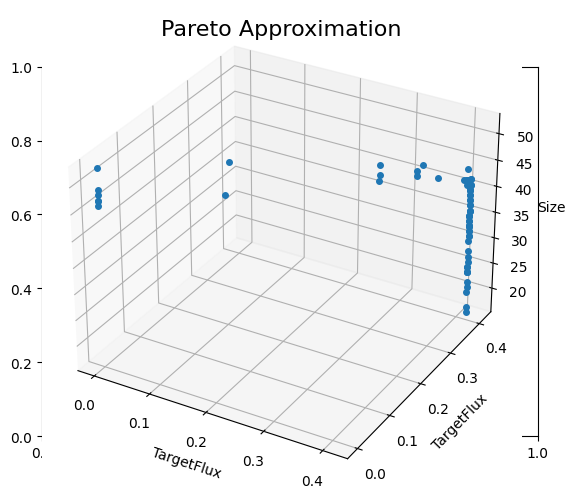

In [26]:
ea.plot()

We may even simulate one of the solution

In [27]:
solution = solutions[5]
solution

[0.41144179768074646, 0.41144179766115907, 35];{'b0734_ec2': 0, 'b2465_ec2': 0, 'b4122_ec2': 0, 'b4153_ec1': 0, 'b0474_ec2': 0, 'b0978_ec2': 0, 'b0733_ec2': 0, 'b2976_ec2': 0, 'b0811_ec2': 0, 'b0809_ec2': 0, 'b4154_ec2': 0, 'b0903_ec2': 0, 'b2297_ec2': 0, 'b1297_ec2': 0, 'b0721_ec2': 0, 'b0724_ec2': 0, 'b1812_ec2': 0, 'b1479_ec2': 0, 'b3386_ec2': 0, 'b1849_ec2': 0, 'b0755_ec2': 0, 'b0767_ec2': 0, 'b2276_ec2': 0, 'b1478_ec2': 0, 'b0114_ec2': 0, 'b3115_ec2': 0, 'b1611_ec2': 0, 'b2097_ec2': 0, 'b2288_ec2': 0, 'b0116_ec2': 0, 'b1276_ec2': 0, 'b1702_ec2': 0, 'b1101_ec2': 0, 'b3735_ec2': 0, 'b3736_ec2': 0}

In [28]:
problem.simulate(solution=solution.values,method=regComFBA).find('BIOMASS',show_nulls=True)

Set parameter FeasibilityTol to value 1e-09
Set parameter OptimalityTol to value 1e-09


,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.411442
BIOMASS_Ecoli_core_w_GAM_ec2,0.411442


or have a look to the reactions that were 'deleted'

In [29]:
problem.solution_to_constraints(solution.values)

{'PDH_ec2': 0,
 'ME1_ec2': 0,
 'ATPS4r_ec2': 0,
 'NADH16_ec2': 0,
 'PGL_ec2': 0,
 'AKGDH_ec2': 0,
 'FRD7_ec2': 0,
 'FRD7_ec1': 0,
 'ADK1_ec2': 0,
 'SUCDi_ec2': 0,
 'CYTBD_ec2': 0,
 'PPS_ec2': 0,
 'GLNabc_ec2': 0}

In [30]:
problem.simulate(solution=solution.values,method='pFBA').find('BIOMASS',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.415598
BIOMASS_Ecoli_core_w_GAM_ec2,0.415598
